# synth-examples

This code was used to generate "artificial" warpings to be reconstructed by different methods in the thesis.

In [2]:
from scipy.ndimage.interpolation import geometric_transform
from utils import load_image
from stnwarp import gaussian_kernel, plot_flow, plot_flow_arrows, transfer_patch, sample_offsets, pad_image, unpad_image
import matplotlib.pyplot as plt
import numpy as np
from skimage.transform import warp
from tqdm import tqdm_notebook as tqdm
from random import randint, random
from colorsys import hsv_to_rgb
import scipy.stats as st

In [3]:
def gkern(kernlen=21, nsig=3):
    """Returns a 2D Gaussian kernel array."""

    interval = (2*nsig+1.)/(kernlen)
    x = np.linspace(-nsig-interval/2., nsig+interval/2., kernlen+1)
    kern1d = np.diff(st.norm.cdf(x))
    kernel_raw = np.sqrt(np.outer(kern1d, kern1d))
    kernel = kernel_raw/kernel_raw.sum()
    return kernel

def get_coordinate_map(width, height):
    xx, yy = np.meshgrid(range(width), range(height))
    return np.stack((xx,yy), axis=2).astype(np.float64)

def do_geo_warp(image, field):
    def mapper(t):
        x,y = t
        tx, ty = field[x,y]
        return x+tx, y+ty
    return geometric_transform(image, mapper, mode='nearest')

# reconstruct images with warps
def get_merged_warp(fields):
    total_warp = np.copy(fields[0])#np.copy(image)
    for field in fields[1:]:
        total_warp[...,0] = do_geo_warp(total_warp[...,0], field)
        total_warp[...,1] = do_geo_warp(total_warp[...,1], field)
    return total_warp

def warp_from_vfields(image, vfields):
    more_fields = np.concatenate([np.reshape(get_coordinate_map(*image.shape),(1,*image.shape,2)),-vfields],axis=0)
    total_warp = get_merged_warp(more_fields)
    total_warp = np.transpose(total_warp, axes=[2,0,1])
    return warp(image.T, total_warp,mode='edge')

(256, 256)


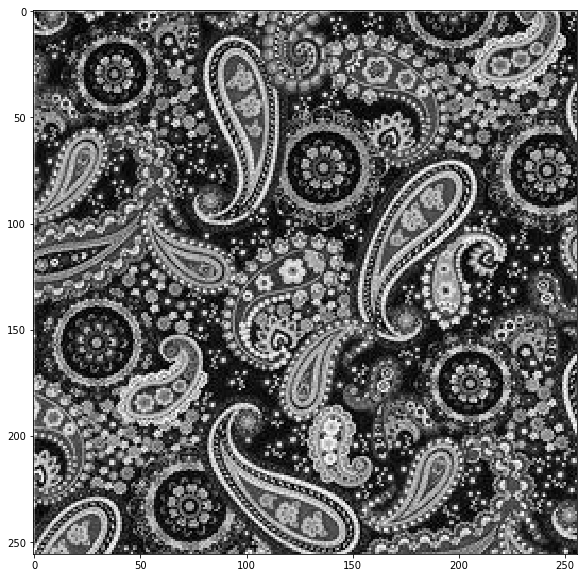

In [11]:
image = load_image('images/dtd/paisley_0128.jpg',scale=1.,astype='grayscale')
folder = 'images/generated'
sedge = min(*image.shape)
image = image[:sedge,:sedge]
print(image.shape)

plt.figure(figsize=(10,10))
plt.imshow(image, cmap='gray')

In [9]:
mask = gkern(image.shape[0], 0.1)
mask = (mask - mask[127,0])
mask = mask.clip(0,1)
mask /= mask.max()

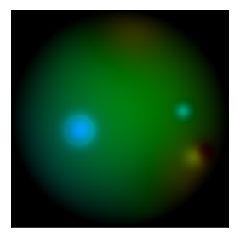

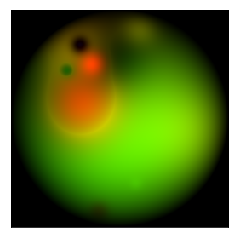

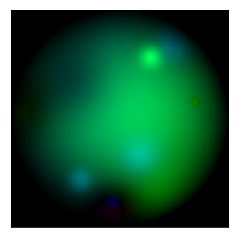

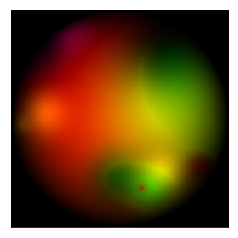

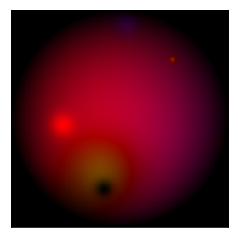

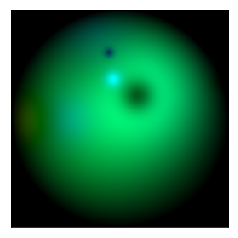

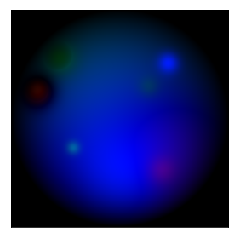

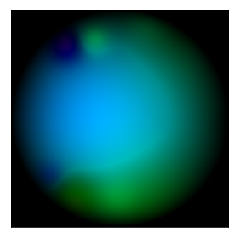

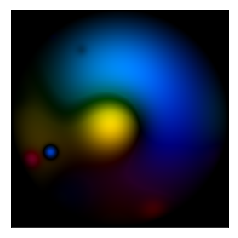

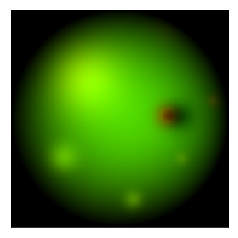

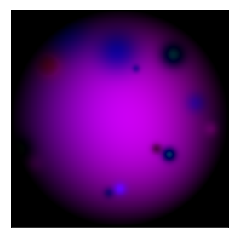

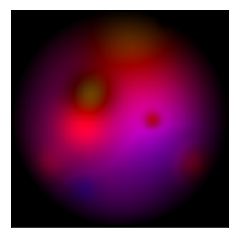

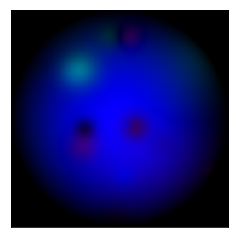

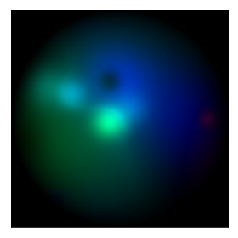

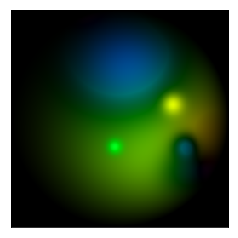

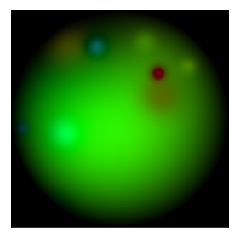

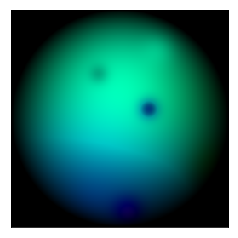

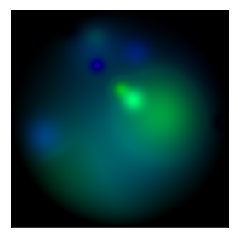

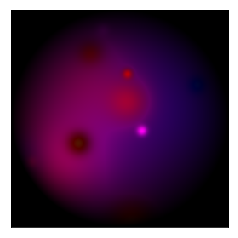

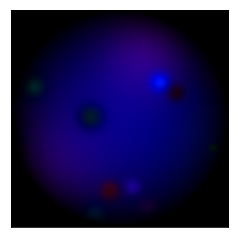

In [12]:
PADDING = image.shape[0]*2
gauss_size = image.shape[0]*3
num_patches = 50
scale = 60 # 60 for paisley, 30 for grid

for i in tqdm(range(20)):
    
    vfields_x = np.zeros_like(image)
    vfields_x = pad_image(vfields_x, PADDING)
    vfields_y = np.zeros_like(image)
    vfields_y = pad_image(vfields_y, PADDING)

    vals = np.random.rand(num_patches,2)*scale - scale/2
    sigmas = np.abs(np.random.randn(num_patches))*(PADDING/8)

    for sig, val in zip(sigmas, vals):
        patch_off = sample_offsets(vfields_x.shape, (gauss_size,gauss_size), 1)[0]
        gauss_x = gkern(gauss_size, sig)
        gauss_x /= np.max(gauss_x)
        gauss_y = gkern(gauss_size, sig)
        gauss_y /= np.max(gauss_y)
        transfer_patch(vfields_x,gauss_x*val[0],patch_off,mode='add')
        transfer_patch(vfields_y,gauss_y*val[1],patch_off,mode='add')

    vfields = np.zeros((1,*image.shape,2))
    vfields_x = unpad_image(vfields_x, PADDING)
    vfields_y = unpad_image(vfields_y, PADDING)
    vfields[0,:,:,0] = vfields_x * mask
    vfields[0,:,:,1] = vfields_y * mask
    warped = warp_from_vfields(image, vfields)

    np.save('{}/auto{}'.format(folder,i), vfields)
    plt.imsave('{}/auto{}'.format(folder,i), warped, cmap='gray')
    fig, ax = plt.subplots(1,1)
    plot_flow(ax, np.rollaxis(vfields[0],2))
    ax.set_xticks([])
    ax.set_yticks([])
    plt.savefig('{}/auto{}f'.format(folder,i), bbox_inches='tight', dpi=300)

In [4]:
def plot_flow(ax, flow):
    angles = np.arctan2(flow[0], -flow[1])
    angles = (angles + np.pi) / (2 * np.pi)
    ax.set_aspect('equal', 'box')
    mags = np.linalg.norm(flow, axis=0)
    mags /= np.max(mags)

    angles[np.isnan(angles)] = 0.
    mags[np.isnan(mags)] = 0.

    vis = np.zeros((flow.shape[2], flow.shape[1], 3))
    for j in range(flow.shape[2]):
        for k in range(flow.shape[1]):
            vis[j, k] = hsv_to_rgb(angles[k, j], 1., mags[k, j])


    vis = np.transpose(vis, axes=[1, 0, 2])

    ax.imshow(vis)
    
def plot_flow_arrows(ax, flow, width, height, s=1, scale=1):
    angles = (np.arctan2(flow[0], -flow[1])+np.pi)/(2*np.pi)
    mynorm = plt.Normalize(vmin=0, vmax=1)

    ax.set_aspect('equal', 'box')
    ax.quiver(range(0, width, s), range(0, height, s), flow[1, ::s, ::s], flow[0, ::s, ::s], angles[::s,::s],
              angles='xy', scale=scale, scale_units='xy', cmap='hsv', norm=mynorm)
    ax.set_xlim(0, width)
    ax.set_ylim(height, 0)

C:\Users\leifv\Anaconda3\envs\opticalflow-interpolation\lib\site-packages\skimage\transform\_warps.py:24: UserWarning: The default multichannel argument (None) is deprecated.  Please specify either True or False explicitly.  multichannel will default to False starting with release 0.16.
  warn('The default multichannel argument (None) is deprecated.  Please '
C:\Users\leifv\Anaconda3\envs\opticalflow-interpolation\lib\site-packages\skimage\transform\_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\leifv\Anaconda3\envs\opticalflow-interpolation\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


(1, 200, 200, 2)


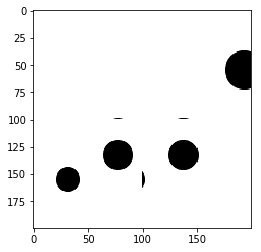

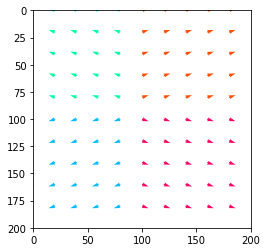

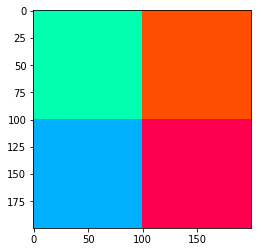

In [6]:
im = load_image('images/circles2.png', astype='grayscale')
plt.imshow(im, cmap='gray')
plt.savefig('images/circles_plot.png', bbox_inches='tight', dpi=300)

vfields = np.zeros((1,*im.shape,2))

# upper left
vfields[0,:100,:100,0] = -10
vfields[0,:100,:100,1] = -30

# upper right
vfields[0,100:,:100,0] = 10
vfields[0,100:,:100,1] = -30

# lower left
vfields[0,:100,100:,0] = -10
vfields[0,:100,100:,1] = 30

# upper right
vfields[0,100:,100:,0] = 10
vfields[0,100:,100:,1] = 30


print(vfields.shape)

imw = warp_from_vfields(im, vfields)
plt.imshow(imw,'gray')
plt.savefig('images/circles_moved.png', bbox_inches='tight', dpi=300)

fig, ax = plt.subplots(1,1)
plot_flow_arrows(ax, np.rollaxis(vfields[0], 2), *im.shape, scale=5, s=20)
plt.show()

fig, ax = plt.subplots(1,1)
plot_flow(ax, np.rollaxis(vfields[0], 2))
plt.savefig('images/circles_moved_flow.png', bbox_inches='tight', dpi=300)

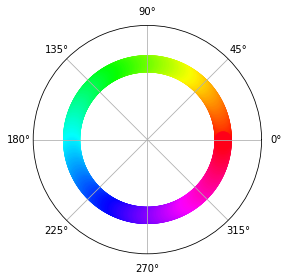

In [7]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

xval = np.arange(0, 2*np.pi, 0.01)
yval = np.ones_like(xval)

colormap = plt.get_cmap('hsv')
norm = mpl.colors.Normalize(0.0, 2*np.pi)

ax = plt.subplot(1, 1, 1, polar=True)
ax.scatter(xval, yval, c=xval, s=300, cmap=colormap, norm=norm, linewidths=0)
ax.set_yticks([])

plt.tight_layout()
plt.savefig('images/colorwheel.png', bbox_inches='tight', dpi=300)